In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras import datasets, utils
import matplotlib.pyplot as plt
import pandas as pd
import qrcode
import os
import cv2
from pyzbar.pyzbar import decode

In [2]:
IMG_ROOT_DIR = "./small_QR_codes"
# Global params for loading the images
batch_size = 8
img_height = 76
img_width = 76

In [3]:
qr_train, qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Splitting training set into validation and training set...")
qr_train, qr_val = utils.split_dataset(
    qr_train, 
    left_size=0.8,
    shuffle = True,
    seed = 123)
    
qr_train = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

qr_val = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 50000 files belonging to 2 classes.
Using 40000 files for training.
Using 10000 files for validation.
Splitting training set into validation and training set...
Found 50000 files belonging to 2 classes.
Using 40000 files for training.
Found 50000 files belonging to 2 classes.
Using 10000 files for validation.
Found 50000 files belonging to 2 classes.


In [4]:
qr_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 76, 76, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

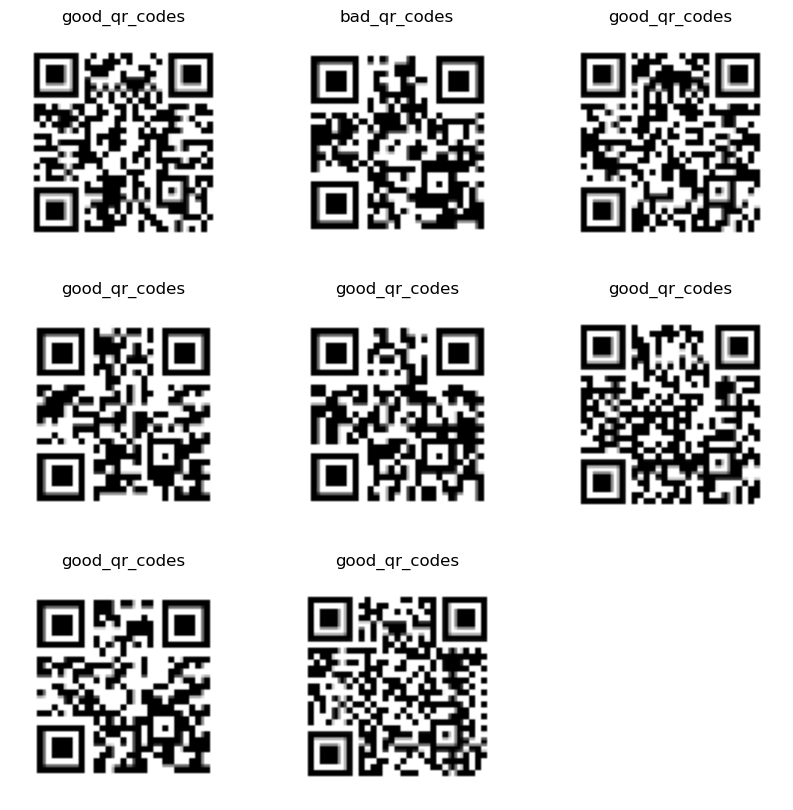

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in qr_train.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(qr_train.class_names[labels[i]])
    plt.axis("off")

In [6]:
# Show image sizes and other info (batch_size, height, width, color_channels)
for image_batch, labels_batch in qr_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 76, 76, 3)
(8,)


In [7]:
# Normalization / Scaling of colors
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''
# Do the same for the validation set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Do the same for the testing set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
'''

0.0 1.0


'\n# Do the same for the validation set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n\n# Do the same for the testing set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n'

In [8]:
# Cache datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

qr_train = qr_train.cache().prefetch(buffer_size=AUTOTUNE)
# qr_val = qr_val.cache().prefetch(buffer_size=AUTOTUNE)
qr_test = qr_test.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Create a model
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_width, img_height, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile (Adam)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

C:\Users\curse\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 74, 74, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 35, 35, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         200,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,482 (861.26 KB)

 Trainable params: 220,482 (861.26 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    qr_train,
    validation_data=qr_val,
    epochs=3
)

Epoch 1/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 242s 47ms/step - accuracy: 0.7752 - loss: 1.1703 - val_accuracy: 0.7831 - val_loss: 0.5061
Epoch 2/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 150s 30ms/step - accuracy: 0.7870 - loss: 0.4931 - val_accuracy: 0.8002 - val_loss: 0.4572
Epoch 3/3
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 152s 30ms/step - accuracy: 0.8090 - loss: 0.4454 - val_accuracy: 0.8021 - val_loss: 0.4425


In [11]:
evaluation = model.evaluate(qr_test)
print("Accuracy of testing: {}".format(evaluation[1]))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 114s 18ms/step - accuracy: 0.8051 - loss: 0.4355
Accuracy of testing: 0.8059800267219543


In [25]:
def predict_qr_code(image_path, model):
    # Read and preprocess the input image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (76, 76))
    resized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]

    # Decode QR code using pyzbar
    decoded_objects = decode(image)
    if decoded_objects:
        extracted_text = decoded_objects[0].data.decode('utf-8')
        print("Decoded QR code text:", extracted_text)

        # Perform model prediction
        predicted_probability = model.predict(np.expand_dims(resized_image, axis=0))[0][0]

        # Convert predicted probability to label
        predicted_label = "good" if predicted_probability < -0.17 else "bad"

        print("Predicted label:", predicted_label)
        return predicted_label
    else:
        print("No QR code found or unable to decode.")
        return None

In [26]:
image_path = "./testing.png"  
predicted_label = predict_qr_code(image_path, model) 

image_path = "./six.png"  
predicted_label = predict_qr_code(image_path, model) 

image_path = "./real.png"  
predicted_label = predict_qr_code(image_path, model) 

image_path = "./one.png"  
predicted_label = predict_qr_code(image_path, model) 

Decoded QR code text: vermillionriverwatershed.org/tmp/update.paypal.com.secure.cmd.login.dispatch.cgi-bin.confirm.activ.cmd.dispatch.webscr/4f4cc252e86bac9f6ceca4d7fe6eda3e/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted label: bad
Decoded QR code text: harquivo.com.br/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted label: bad
Decoded QR code text: http://github.com
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted label: good
Decoded QR code text: www.123plaza.com/ws_reg_intro_eng_us.html
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted label: good


# 